
 # BGE-M3 Retrieval 

## Sentence-Level

In [ ]:
import os
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm
from langchain.schema import Document
from sentence_transformers import SentenceTransformer

class FaissRetriever:
    def __init__(self, documents, model_name="BAAI/bge-m3"):
        """
        Initialize FAISS retriever with documents and embedding model.
        Automatically filter, encode, and index documents.
        """
        # Filter and prepare documents
        self.documents = [Document(page_content=line.strip(), metadata={"id": idx}) 
                          for idx, line in enumerate(documents) if len(line.strip()) > 5]
        
        # Initialize embedding model
        self.model = SentenceTransformer(model_name)
        
        # Generate and normalize embeddings
        text_contents = [doc.page_content for doc in self.documents]
        embeddings = self.model.encode(text_contents, convert_to_tensor=False)
        self.embeddings = np.array(embeddings).astype("float32")
        faiss.normalize_L2(self.embeddings)

        # Build FAISS index
        self.index = faiss.IndexFlatIP(self.embeddings.shape[1])
        self.index.add(self.embeddings)

    def GetFaissTopK(self, query, topk):
        """
        Retrieve top-k most relevant documents with similarity scores.
        Returns: List[Document] with scores in metadata.
        """
        # Generate and normalize query embedding
        query_embedding = self.model.encode([query], convert_to_tensor=False)
        query_embedding = np.array(query_embedding).astype("float32")
        faiss.normalize_L2(query_embedding)

        valid_topk = min(topk, len(self.documents))
        scores, indices = self.index.search(query_embedding, valid_topk)

        # Return results with scores
        results = []
        for idx, score in zip(indices[0], scores[0]):
            original_doc = self.documents[idx]
            new_metadata = original_doc.metadata.copy()
            new_metadata["score"] = float(score)
            results.append(Document(
                page_content=original_doc.page_content,
                metadata=new_metadata
            ))
        return results


# File paths
TEXT_FILE_PATH = "../data/MSE-KG/KGPreprocess/verbalized_triples_np.txt"
EXCEL_FILE_PATH = "../data/MSE-KG/KG_QA/Competency_Question.xlsx"

# Load documents and questions
with open(TEXT_FILE_PATH, "r", encoding="utf-8") as file:
    document_lines = file.readlines()

faiss_retriever = FaissRetriever(document_lines)
df = pd.read_excel(EXCEL_FILE_PATH)
competency_questions = df["Competency Question"].tolist()

# Prepare result DataFrame
result_df = df[["Competency Question", "Ground Truth"]].copy()


# Process different top_k values
for top_k in range(10, 101, 10):
    print(f"\nProcessing with top_k={top_k}...")
    merged_results = []

    for question in tqdm(competency_questions, desc=f"TopK={top_k}"):
        try:
            docs = faiss_retriever.GetFaissTopK(question, top_k)
            unique_docs = {}

            for doc in docs:
                content = doc.page_content
                score = doc.metadata["score"]
                if content not in unique_docs or unique_docs[content]["score"] < score:
                    unique_docs[content] = {"content": content, "score": score}

            sorted_docs = sorted(unique_docs.values(), key=lambda x: x["score"], reverse=True)
            formatted_result = " | ".join([
                f"{doc['content']} ({doc['score']:.3f})" for doc in sorted_docs
            ])
            merged_results.append(formatted_result)

        except Exception as e:
            print(f"Failed to process question: {question[:30]}... Error: {e}")
            merged_results.append("ERROR")

    # Add results to DataFrame
    result_df[f"FAISS_TopK_{top_k}"] = merged_results

    # Export to Excel
    output_path = f"../data/MSE-KG/BGEM3/Contexts_by_BGE_M3_{top_k}_sentence_level.xlsx"
    result_df.to_excel(output_path, index=False)
    print(f"Saved to {output_path}")

print("All processing completed.")

To create a offline vector dataset, it needs 10m27s.

## Paragraph-Level

In [ ]:
import os
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm
from langchain.schema import Document
from sentence_transformers import SentenceTransformer

class FaissRetriever:
    def __init__(self, documents, model_name="BAAI/bge-m3"):
        """
        Initialize FAISS retriever with documents and embedding model.
        Automatically filter, encode, and index documents.
        """
        # Filter and prepare documents
        self.documents = [Document(page_content=line.strip(), metadata={"id": idx}) 
                          for idx, line in enumerate(documents) if len(line.strip()) > 5]
        
        # Initialize embedding model
        self.model = SentenceTransformer(model_name)
        
        # Generate and normalize embeddings
        text_contents = [doc.page_content for doc in self.documents]
        embeddings = self.model.encode(text_contents, convert_to_tensor=False)
        self.embeddings = np.array(embeddings).astype("float32")
        faiss.normalize_L2(self.embeddings)

        # Build FAISS index
        self.index = faiss.IndexFlatIP(self.embeddings.shape[1])
        self.index.add(self.embeddings)

    def GetFaissTopK(self, query, topk):
        """
        Retrieve top-k most relevant documents with similarity scores.
        Returns: List[Document] with scores in metadata.
        """
        # Generate and normalize query embedding
        query_embedding = self.model.encode([query], convert_to_tensor=False)
        query_embedding = np.array(query_embedding).astype("float32")
        faiss.normalize_L2(query_embedding)

        valid_topk = min(topk, len(self.documents))
        scores, indices = self.index.search(query_embedding, valid_topk)

        # Return results with scores
        results = []
        for idx, score in zip(indices[0], scores[0]):
            original_doc = self.documents[idx]
            new_metadata = original_doc.metadata.copy()
            new_metadata["score"] = float(score)
            results.append(Document(
                page_content=original_doc.page_content,
                metadata=new_metadata
            ))
        return results


# === Main Execution ===


# File paths
TEXT_FILE_PATH = "../data/MSE-KG/KGPreprocess/verbalized_paragraphs.txt"
EXCEL_FILE_PATH = "../data/MSE-KG/KG_QA/Competency_Question.xlsx"

# Load documents and questions
with open(TEXT_FILE_PATH, "r", encoding="utf-8") as file:
    document_lines = file.readlines()

faiss_retriever = FaissRetriever(document_lines)
df = pd.read_excel(EXCEL_FILE_PATH)
competency_questions = df["Competency Question"].tolist()

# Prepare result DataFrame
result_df = df[["Competency Question", "Ground Truth"]].copy()


# Process different top_k values
for top_k in range(10, 101, 10):
    print(f"\nProcessing with top_k={top_k}...")
    merged_results = []

    for question in tqdm(competency_questions, desc=f"TopK={top_k}"):
        try:
            docs = faiss_retriever.GetFaissTopK(question, top_k)
            unique_docs = {}

            for doc in docs:
                content = doc.page_content
                score = doc.metadata["score"]
                if content not in unique_docs or unique_docs[content]["score"] < score:
                    unique_docs[content] = {"content": content, "score": score}

            sorted_docs = sorted(unique_docs.values(), key=lambda x: x["score"], reverse=True)
            formatted_result = " | ".join([
                f"{doc['content']} ({doc['score']:.3f})" for doc in sorted_docs
            ])
            merged_results.append(formatted_result)

        except Exception as e:
            print(f"Failed to process question: {question[:30]}... Error: {e}")
            merged_results.append("ERROR")

    # Add results to DataFrame
    result_df[f"FAISS_TopK_{top_k}"] = merged_results

    # Export to Excel
    output_path = f"../data/MSE-KG/Contexts_by_BGE_M3_{top_k}_paragraph_level.xlsx"
    result_df.to_excel(output_path, index=False)
    print(f"Saved to {output_path}")

print("All processing completed.")

# Reranker

In [ ]:
# import os
# import pandas as pd
# from tqdm import tqdm
# from sentence_transformers import CrossEncoder

# input_dir = "../data/MSE-KG/BGEM3"
# model_name = "BAAI/bge-reranker-large"
# batch_size = 2  
# max_query_len = 200
# max_doc_len = 300

# print(f"Loading reranker model: {model_name}")
# reranker = CrossEncoder(model_name)

# for top_k in range(10, 101, 10):
#     input_file = os.path.join(input_dir, f"Contexts_by_BGE_M3_{top_k}_verbalized_paragraphs_up.xlsx")
#     output_file = os.path.join(input_dir, f"Contexts_Reranked_by_BGE_M3_{top_k}_verbalized_paragraphs_up.xlsx")

#     if not os.path.exists(input_file):
#         print(f"File not found: {input_file}")
#         continue

#     print(f"\nProcessing: {input_file}")
#     df = pd.read_excel(input_file)

#     original_column = f"FAISS_TopK_{top_k}"
#     if original_column not in df.columns:
#         print(f"Missing column: {original_column}. Skipping.")
#         continue

#     reranked_results = []

#     for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Reranking TopK={top_k}"):
#         query = str(row["Competency Question"])[:max_query_len]
#         result = row.get(original_column)

#         if isinstance(result, str) and " | " in result:
#             candidates = result.split(" | ")
#             contents = []
#             for item in candidates:
#                 try:
#                     content = item.rsplit("(", 1)[0].strip()
#                     contents.append(content[:max_doc_len])
#                 except:
#                     continue

#             if not contents:
#                 reranked_results.append("ERROR: No valid content")
#                 continue

#             try:
#                 pairs = [(query, doc) for doc in contents]
#                 scores = reranker.predict(pairs, batch_size=batch_size)
#                 reranked = sorted(zip(contents, scores), key=lambda x: x[1], reverse=True)
#                 formatted = " | ".join([f"{c} ({s:.3f})" for c, s in reranked])
#                 reranked_results.append(formatted)
#             except Exception as e:
#                 reranked_results.append(f"ERROR: {str(e)}")
#         else:
#             reranked_results.append("EMPTY or MALFORMED")

#     reranked_column = f"Reranked_BGE_TopK_{top_k}_verbalized"
#     df[reranked_column] = reranked_results
#     df.to_excel(output_file, index=False)
#     print(f"Saved reranked results to: {output_file}")

# print("\n✅ All reranking completed.")

# Generation

In [ ]:
# Generation Prompt Update
GENRATION_PROMPT_TEMPLATE = '''
Given the following question and combined factual contexts from two sources (triples and text):

Question: {question}
Context(s): {contexts}

Instructions:
1. Use Contexts Effectively: While the contexts provide information, they may contain redundancy. Focus on the most relevant triples that directly answer the question.
2. Leverage Understanding: Utilize your ability to comprehend and deduce the most essential details, even if some triples are less relevant or repetitive.
3. Direct Answers: Provide answers in a list format of phrases if appropriate, without any introductory phrases or complete sentences. Only provide the key facts.
4. Avoid Irrelevant Details: Omit information that does not directly contribute to answering the question.
5. List Format: When listing items, separate them with semicolons (;) instead of using dashes (-) or other symbols.
6. No Prefixes: Do not include any introductory phrases like "Based on the provided contexts" or "Answer:".
7. No Answer Indication: If no relevant information is found, simply return "(No Answer)" without any additional explanation.

Examples:
Question: Who was the first president of the United States?
Contexts:
George Washington was the first president of the United States.
George Washington took office in 1789.
George Washington won both presidential elections.

George Washington
'''

In [ ]:
from openai import OpenAI
import pandas as pd
import time
import logging
import os
from tqdm import tqdm

# Configuration Constants
BASE_URL = "https://api.deepseek.com"
MODEL_NAME = "deepseek-chat"
MAX_TOKENS = 1000
RETRY_COUNT = 3
SLEEP_INTERVAL = 1  # Rate limiting between API calls
DATA_DIR = "../data/MSE-KG/BGEM3/"
LOG_PATH = '../log/test.log'

# Set up logging
logging.basicConfig(
    filename=LOG_PATH,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

def generate_answer(question: str, context: str) -> str:
    """Generates answer using OpenAI API with retry mechanism."""
    if not context.strip():
        return "[No Answer]"

    prompt = GENRATION_PROMPT_TEMPLATE.format(question=question, contexts=context)
    
    for attempt in range(RETRY_COUNT):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=MAX_TOKENS
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            logging.warning(f"API error (Attempt {attempt+1}/{RETRY_COUNT}): {str(e)}")
            time.sleep(2 ** attempt)  # Exponential backoff
    return "[API Error: Maximum retries exceeded]"

def process_questions(df: pd.DataFrame, context_column: str) -> tuple[list, list]:
    """Processes dataframe rows and generates answers."""
    answers = []
    failed_indices = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Answers"):
        try:
            question = str(row.get('Competency Question', ''))
            context = str(row.get(context_column, ''))
            answer = generate_answer(question, context)
            answers.append(answer)

            if index % 10 == 0:
                logging.info(f"Processed {index+1}/{len(df)}")

            time.sleep(SLEEP_INTERVAL)  # Global rate limiting
        except Exception as e:
            logging.error(f"Row {index} failed: {str(e)}")
            answers.append("[Error]")
            failed_indices.append(index)

    return answers, failed_indices

def process_single_file(input_path, output_path, top_k):
    try:
        df = pd.read_excel(input_path)
        
        # Get the correct context column name
        context_column = f"FAISS_TopK_{top_k}"
        
        if context_column not in df.columns:
            raise ValueError(f"Column {context_column} not found in the input file")

        logging.info(f"Processing: {input_path}")
        answers, failed = process_questions(df, context_column)

        df['Answer'] = answers
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df.to_excel(output_path, index=False)
        
        logging.info(f"Saved answers to {output_path}")
        print(f"[✓] Saved: {output_path}")
        if failed:
            logging.warning(f"Failed rows in {input_path}: {len(failed)}")
            print(f"[-] {len(failed)} rows failed in {input_path}")

    except Exception as e:
        logging.error(f"Error processing {input_path}: {str(e)}")
        print(f"[X] Error with file {input_path}: {str(e)}")

if __name__ == "__main__":
    for top_k in range(10, 101, 10):
        input_path = f"{DATA_DIR}Contexts_by_BGE_M3_{top_k}_paragraph_level.xlsx"
        output_path = f"{DATA_DIR}Predicted_Answers_BGE_M3_{top_k}_paragraph_level.xlsx"
        process_single_file(input_path, output_path, top_k)

# Evaluation

## Paragraph Level

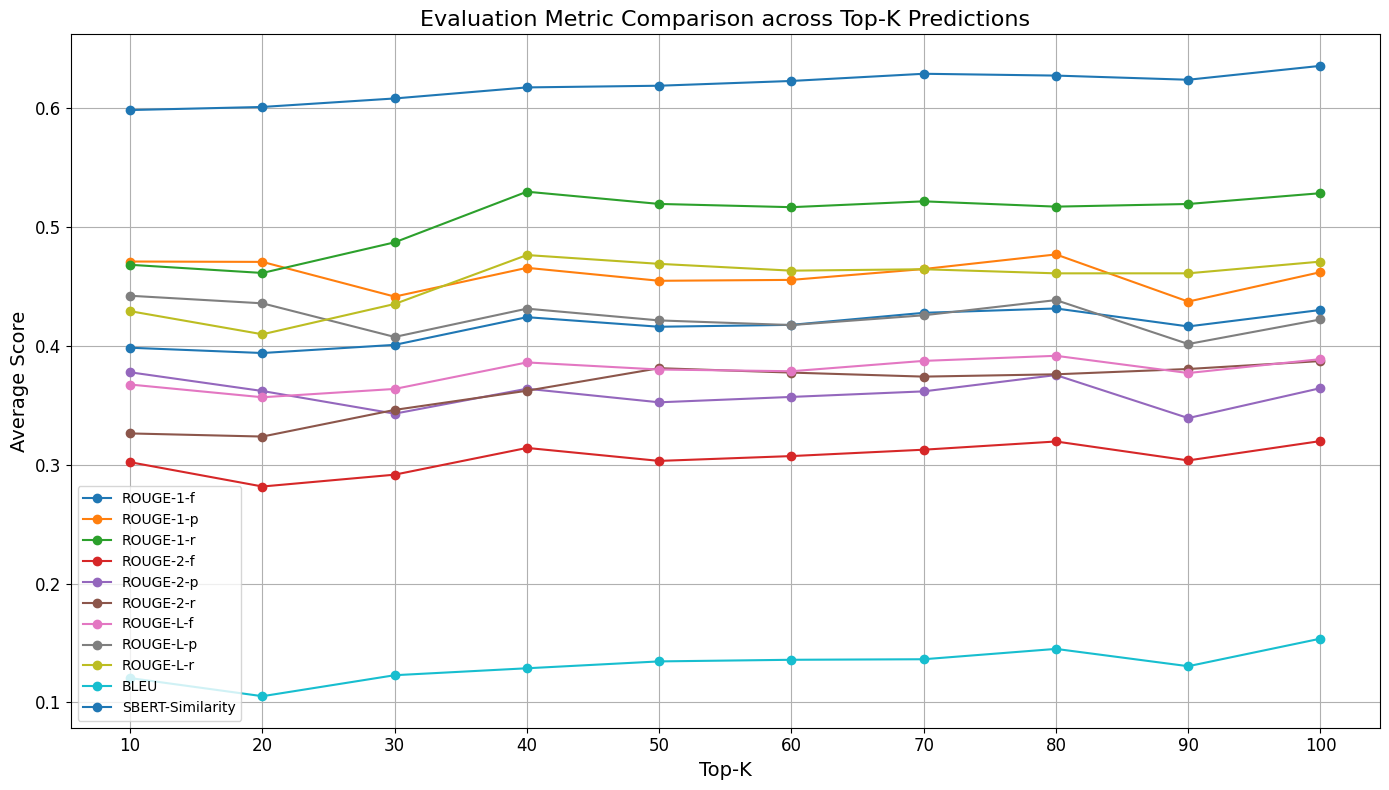

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/BGEM3/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:

    file_name = f"Predicted_Answers_BGE_M3_{top_k}_paragraph_level.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_BGE_M3_{top_k}_paragraph_level.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/BGEM3/Evaluation_Comparison_Averages_BGE_M3_Paragraph_Level.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/BGEM3/Evaluation_Comparison_Averages_BGE_M3_Paragraph_Level.png")
plt.show()

## Sentence-Level 

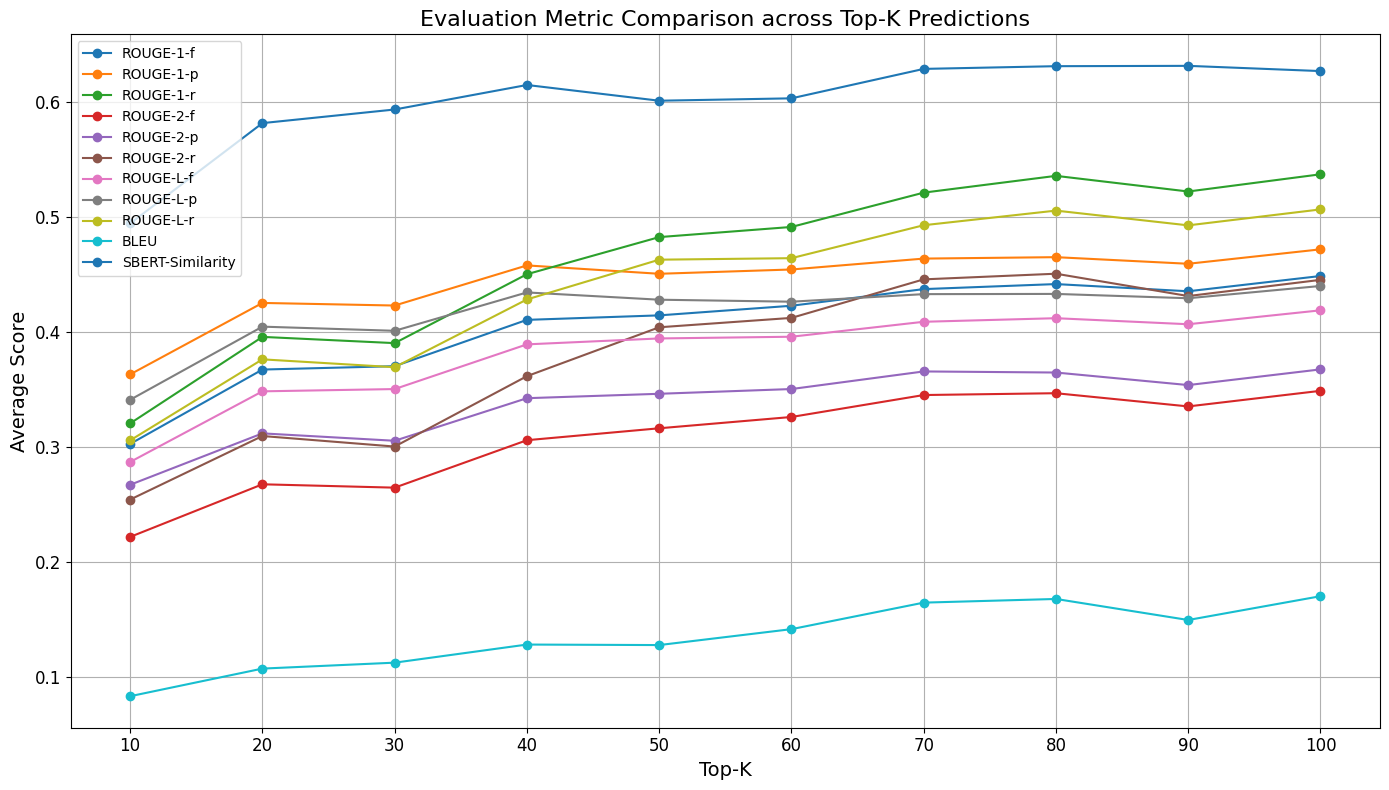

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/BGEM3/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:

    file_name = f"Predicted_Answers_BGE_M3_{top_k}_sentence_level.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_BGE_M3_{top_k}_sentence_level.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/BGEM3/Evaluation_Comparison_Averages_BGE_M3_Sentence_Level.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/BGEM3/Evaluation_Comparison_Averages_BGE_M3_Sentence_Level.png")
plt.show()